<a href="https://colab.research.google.com/github/JayJihyunKim/workbooks/blob/main/FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pytorch-ignite

     |████████████████████████████████| 184kB 9.1MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [6]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [7]:
#데이터 정규화
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

#트레이닝 셋 다운로드 후 로드
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

#테스트 셋 다운로드 후 로드
validationset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
val_loader = DataLoader(validationset, batch_size=64, shuffle=True)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [8]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()

    self.convlayer1 = nn.Sequential(
        nn.Conv2d(1,32,3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.convlayer2 = nn.Sequential(
        nn.Conv2d(32,64,3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )    

    self.fc1 = nn.Linear(64*6*6,600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(600,120)
    self.fc3 = nn.Linear(120,10)

  def forward(self, x):
    x = self.convlayer1(x)
    x = self.convlayer2(x)
    x = x.view(-1,64*6*6)
    x = self.fc1(x)
    x = self.drop(x)
    x = self.fc2(x)
    x = self.fc3(x)

    return F.log_softmax(x, dim=1)



In [9]:
# 모델, 옵티마이저, 로스 셋팅
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

# 학습셋팅

epochs = 12
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'accuracy':Accuracy(),
    'nll':Loss(criterion),
    'cm':ConfusionMatrix(num_classes=10)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'accuracy':[], 'loss':[]}
validation_history = {'accuracy':[], 'loss':[]}
last_epoch = []

RunningAverage(output_transform=lambda x: x).attach(trainer,'loss')

In [10]:
def score_function(engine):
  val_loss = engine.state.metrics['nll']
  return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [11]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
  train_evaluator.run(train_loader)
  metrics = train_evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['nll']
  last_epoch.append(0)
  training_history['accuracy'].append(accuracy)
  training_history['loss'].append(loss)
  print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}".format(trainer.state.epoch, accuracy, loss))

def log_validation_results(trainer):
  val_evaluator.run(val_loader)
  metrics = val_evaluator.state.metrics  
  accuracy = metrics['accuracy']*100
  loss = metrics['nll']
  validation_history['accuracy'].append(accuracy)
  validation_history['loss'].append(loss)
  print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}".format(trainer.state.epoch, accuracy, loss))

trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)



Training Results - Epoch: 1  Avg accuracy: 89.19 Avg loss: 0.31
Validation Results - Epoch: 1  Avg accuracy: 88.14 Avg loss: 0.34
Training Results - Epoch: 2  Avg accuracy: 90.35 Avg loss: 0.27
Validation Results - Epoch: 2  Avg accuracy: 88.68 Avg loss: 0.32
Training Results - Epoch: 3  Avg accuracy: 92.18 Avg loss: 0.22
Validation Results - Epoch: 3  Avg accuracy: 90.26 Avg loss: 0.28
Training Results - Epoch: 4  Avg accuracy: 93.27 Avg loss: 0.18
Validation Results - Epoch: 4  Avg accuracy: 90.95 Avg loss: 0.26
Training Results - Epoch: 5  Avg accuracy: 94.29 Avg loss: 0.16
Validation Results - Epoch: 5  Avg accuracy: 91.53 Avg loss: 0.24
Training Results - Epoch: 6  Avg accuracy: 94.45 Avg loss: 0.16
Validation Results - Epoch: 6  Avg accuracy: 91.30 Avg loss: 0.25
Training Results - Epoch: 7  Avg accuracy: 95.00 Avg loss: 0.14
Validation Results - Epoch: 7  Avg accuracy: 91.48 Avg loss: 0.25
Training Results - Epoch: 8  Avg accuracy: 95.16 Avg loss: 0.13
Validation Results - Epoch

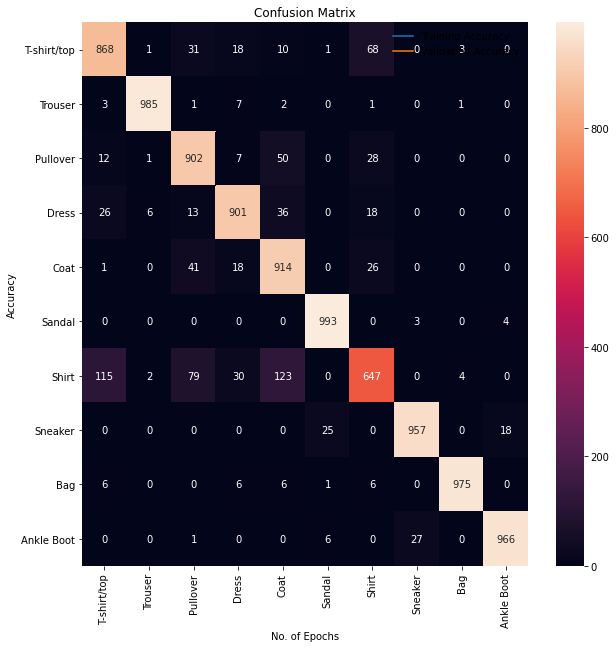

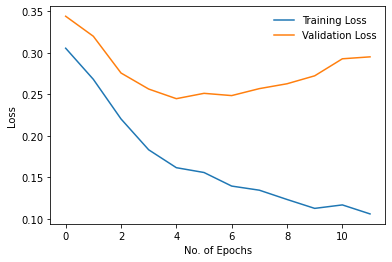

In [12]:
checkpointer = ModelCheckpoint('./saved_models', 'fashionMNIST', n_saved=2, create_dir=True, save_as_state_dict=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'fashionMNIST': model})
trainer.run(train_loader, max_epochs=epochs)

plt.plot(training_history['accuracy'],label="Training Accuracy")
plt.plot(validation_history['accuracy'],label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.show()

plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

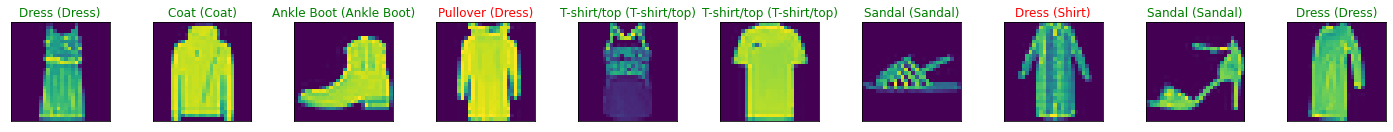

In [13]:
# classes of fashion mnist dataset
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
# creating iterator for iterating the dataset
dataiter = iter(val_loader)
images, labels = dataiter.next()
images_arr = []
labels_arr = []
pred_arr = []
# moving model to cpu for inference 
model.to("cpu")
# iterating on the dataset to predict the output
for i in range(0,10):
    images_arr.append(images[i].unsqueeze(0))
    labels_arr.append(labels[i].item())
    ps = torch.exp(model(images_arr[i]))
    ps = ps.data.numpy().squeeze()
    pred_arr.append(np.argmax(ps))
# plotting the results
fig = plt.figure(figsize=(25,4))
for i in range(10):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.imshow(images_arr[i].resize_(1, 28, 28).numpy().squeeze())
    ax.set_title("{} ({})".format(classes[pred_arr[i]], classes[labels_arr[i]]),
                 color=("green" if pred_arr[i]==labels_arr[i] else "red"))